## Visualizing n random or representative cell in a given well
- Inputs are:
    -  **file_name** - .sql file path for the target plate(or a dataframe)
    -  **well_name** - Well name
    -  **n_cells** - number of single cells you want to visualize
    -  **box_size** - size of box in pixels for cropping a cell
    -  **channels** - list of channels you want to plot
    -  **cell_selection_method** - can be one of the following methods
        - random - generate n randomly selected cells
        - representative - clusters the data and sample from the "closest to mean cluster"
        - geometric_median - plots single sample than is the geometric median of samples
        
        
#### Steps:

- Reading the target well from the input plate 
- Sampling using cell_selection_method 
  

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from singlecell.read import read_single_cell_sql
from singlecell.process import extract_single_cell_samples
from singlecell.visualize import visualize_n_SingleCell
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
# from sklearn.cluster import KMeans
import time

In [2]:
pwd

'/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis'

### Inputs

In [2]:
file_name='/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad'\
'/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015052/SQ00015052.sqlite'

n_cells=6

box_size=100

well_name=["A13"]

# repEnabled= True
# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='random'

channels=["Mito","AGP","DNA","RNA","ER"]

In [ ]:
# python restore_intelligent.py imaging-platform "projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015195/"

### Read single cell data

In [3]:
%%time
df_p_s0=read_single_cell_sql.readSingleCellData_sqlalch_well_subset(file_name,well_name,"Image_Metadata_Well");
df_p_s,_ = edgeCellFilter(df_p_s0);
print("Number of cells: ",df_p_s0.shape[0],"Number of cells after edge cell removel: ",df_p_s.shape[0])

image_width 2160
Inferred edge margin: 85
Number of cells:  2164 Number of cells after edge cell removel:  1965
CPU times: user 7.35 s, sys: 2.82 s, total: 10.2 s
Wall time: 13min 33s


In [ ]:
# df_p_s0[df_p_s0.columns[df_p_s0.columns.str.contains('utline')]]
# df_p_s0.columns[df_p_s0.columns.str.contains('Image_Width_OrigDNA')]

### Create or modify sc dataframe columns for image file names and image paths

In [4]:
# """
# The following columns are needed for generation of single cell images,\
# if you already have it just modify the config file,
# if not you have to generate them
# """

paths={"root_dir":"/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/",\
       "batch_folder": "2016_04_01_a549_48hr_batch1_compressed",\
       "outline_subdir": "/workspace/analysis/cell_outlines_Mito_Project/"
      }

meta_cols={'site':'Image_Metadata_Site',\
            'well':'Image_Metadata_Well',\
            'plate':'Image_Metadata_Plate'}

viz_cols={'center_indicator_columns_x_y': ['Nuclei_Location_Center_X','Nuclei_Location_Center_Y'],\
            'image_path_column_prefix':'PathName_Orig',\
            'image_name_column_prefix':'FileName_Orig'}

fix_paths_params={'paths':paths,\
        'meta_cols':meta_cols,\
        'viz_cols':viz_cols}


def create_image_path_cols(params,df_p_s):
    
    paths=params['paths']
    meta_cols=params['meta_cols']
    viz_cols=params['viz_cols']
    
    for ch in channels:
        df_p_s["PathName_Orig"+ch]=paths["root_dir"]+paths["batch_folder"]+"/images/"+df_p_s[meta_cols['plate']]
        df_p_s["FileName_Orig"+ch]=df_p_s["Image_FileName_Orig"+ch].apply(lambda x: x.replace("tiff","png"))
    
    
    df_p_s["Path_Outlines"] = paths["root_dir"]+paths["outline_subdir"]+\
    df_p_s[meta_cols['well']]+'-'+df_p_s[meta_cols['plate']].astype(str)+'/outlines/'+\
    df_p_s[meta_cols['well']]+'_s'+df_p_s[meta_cols['site']].astype(int).astype(str)+'--cell_outlines.png'    
    
    return df_p_s


# single_cell_viz_config

# original_im_size=sc_df['Image_Width_OrigDNA'].values[0]

### Visualize

cp_features: 1656
cols2remove_manyNulls []
cols2remove_lowVars ['Cytoplasm_Correlation_Costes_AGP_ER', 'Cells_Correlation_Costes_RNA_DNA', 'Nuclei_Children_Cells_Count', 'Nuclei_Correlation_Costes_ER_DNA', 'Nuclei_Correlation_Costes_RNA_DNA', 'Cytoplasm_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_RNA_ER', 'Nuclei_Correlation_Costes_AGP_ER', 'Cytoplasm_Correlation_Costes_ER_RNA', 'Nuclei_Correlation_Costes_Mito_ER', 'Cells_Correlation_Costes_ER_DNA', 'Cells_Correlation_Costes_DNA_ER', 'Nuclei_Correlation_Costes_RNA_Mito', 'Cells_Children_Cytoplasm_Count', 'Nuclei_Children_Cytoplasm_Count', 'Cytoplasm_Correlation_Costes_RNA_ER', 'Cells_Correlation_Costes_AGP_DNA', 'Nuclei_Correlation_Costes_ER_RNA', 'Cytoplasm_Correlation_Costes_Mito_AGP', 'Cytoplasm_Correlation_Costes_AGP_DNA', 'Cells_Correlation_Costes_ER_RNA', 'Nuclei_Correlation_Costes_Mito_AGP', 'Nuclei_Correlation_Costes_AGP_DNA', 'Nuclei_Correlation_Costes_ER_AGP', 'Nuclei_Correlation_Costes_DNA_ER', 'Cytoplasm_Correlati

<IPython.core.display.Javascript object>


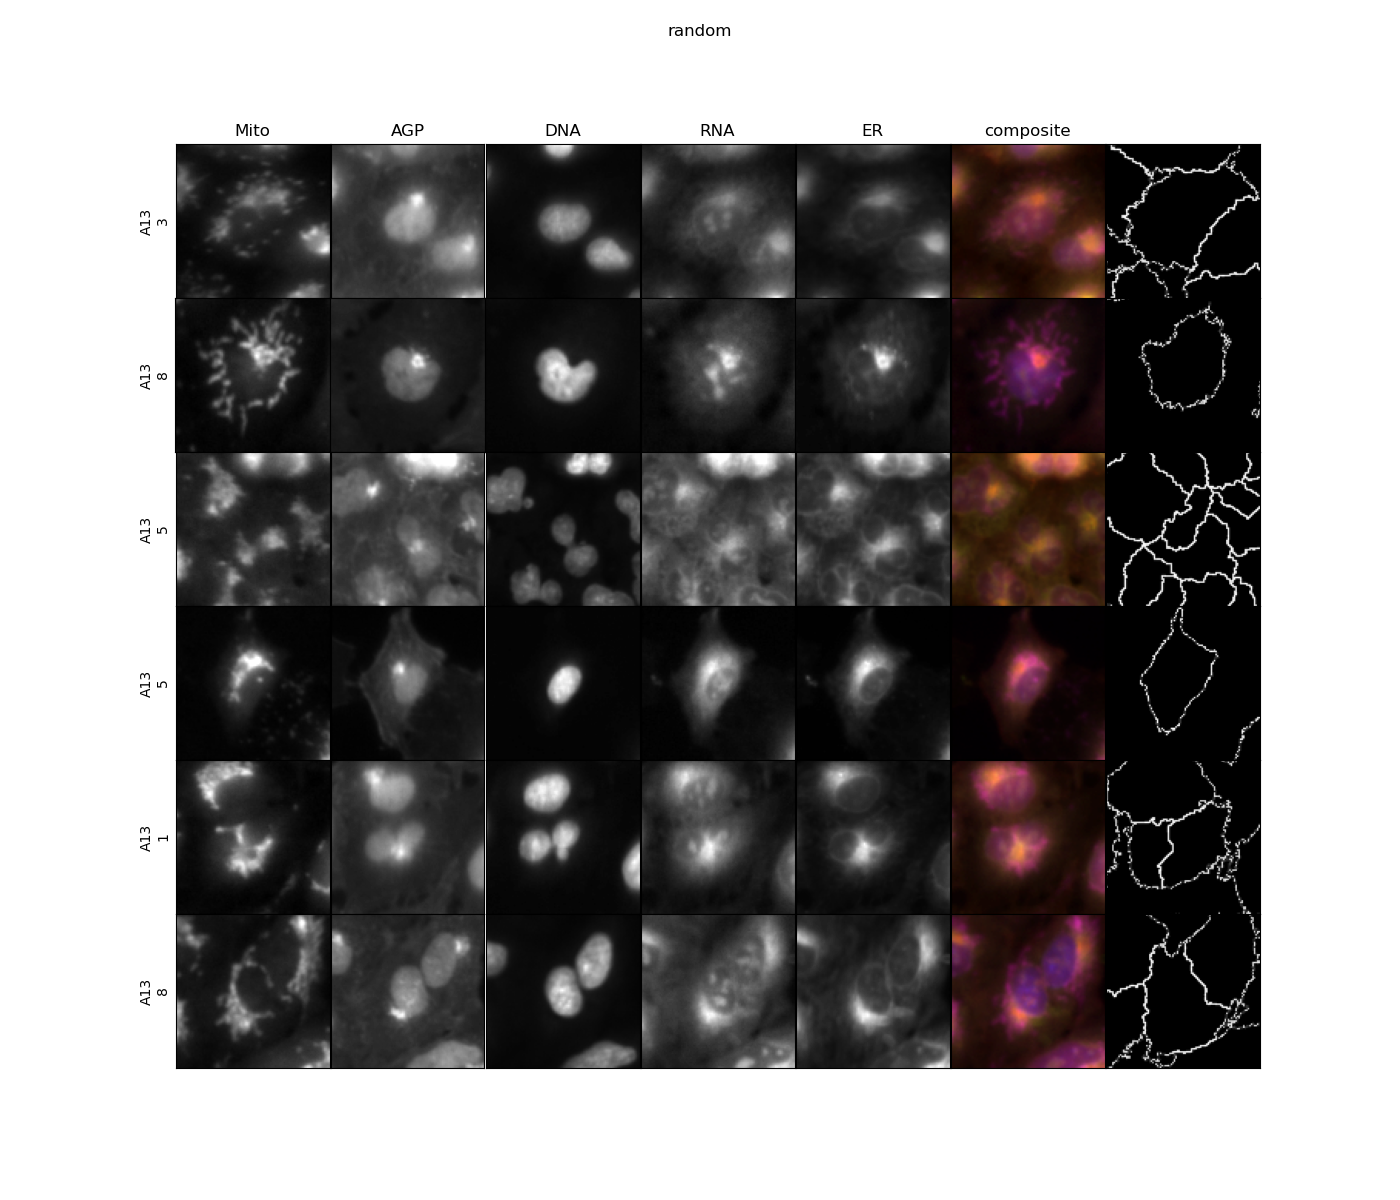

CPU times: user 4.4 s, sys: 9.6 s, total: 14 s
Wall time: 27.6 s


In [36]:
%%time
df_p_s=df_p_s0.copy()

# df_p_s,_ = edgeCellFilter(df_p_s0, edge_margin = int((compressed_im_size/original_im_size)*(box_size/2));
# df_p_s,_ = edgeCellFilter(df_p_s0, edge_margin = int(box_size/2));
# df_p_s,_ = edgeCellFilter(df_p_s0);


df_p_s=create_image_path_cols(fix_paths_params,df_p_s);

cell_selection_method='random'
y_labels=["Image_Metadata_Well","Image_Metadata_Site"]

########## extract single cell samples
df_samples,cp_features_analysis = extract_single_cell_samples.extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);


########## visualize single cell samples
sc_fig=visualize_n_SingleCell.visualize_n_SingleCell(channels,df_samples,box_size,\
            info_columns=y_labels,\
            outline=True,\
            color=True,\
            title=cell_selection_method,\
            compressed=True,compressed_im_size=1080);

In [13]:
# df_samples,
df_p_s.shape,df_p_s0.shape

((2164, 2453), (2164, 2442))

In [43]:
import skimage.io
image=skimage.io.imread('/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/2016_04_01_a549_48hr_batch1_compressed/images/SQ00015052/r01c13f04p01-ch5sk1fk1fl1.png')
xCenter,yCenter=451,1035
# image_cropped = crop_single_cell_image(image,xCenter,yCenter,halfBoxSize)

In [45]:
halfBoxSize=50
im_w,im_h=image.shape;
image_cropped=image[np.maximum(yCenter-halfBoxSize,0):np.minimum(yCenter+halfBoxSize,im_w),\
                    np.maximum(xCenter-halfBoxSize,0):np.minimum(xCenter+halfBoxSize,im_h)]

In [46]:
image_cropped.shape

(95, 100)

In [30]:
np.maximum(yCenter+halfBoxSize,im_w)

1080

In [31]:
np.minimum(yCenter-halfBoxSize,0)

-42

In [37]:
image_cropped.shape

(100, 100)

In [35]:
# image_cropped.shape
np.pad(image_cropped, ((before_y_pad, after_y_pad), (before_x_pad, after_x_pad)), 'minimum').shape

(101, 101)

In [53]:
im_w,im_h=image.shape;
print(im_w,im_h)
#     image_cropped=np.zeros((halfBoxSize*2,halfBoxSize*2))
before_y_pad=0
after_y_pad=0
before_x_pad=0
after_x_pad=0

if xCenter-halfBoxSize<0:
    before_x_pad=abs(xCenter-halfBoxSize)

if yCenter-halfBoxSize<0:
    before_y_pad=abs(yCenter-halfBoxSize)

if xCenter+halfBoxSize>im_w:
    after_x_pad=abs(im_w-xCenter-halfBoxSize)

if yCenter+halfBoxSize>im_h:
    after_y_pad=abs(im_h-yCenter-halfBoxSize)

image_cropped=image[np.maximum(yCenter-halfBoxSize,0):np.minimum(yCenter+halfBoxSize,im_w),\
                    np.maximum(xCenter-halfBoxSize,0):np.minimum(xCenter+halfBoxSize,im_h)]
print('image_cropped',image_cropped.shape)
if np.max([before_y_pad, after_y_pad,before_x_pad, after_x_pad])>0:
    image_cropped=np.pad(image_cropped, ((before_y_pad, after_y_pad), (before_x_pad, after_x_pad)), 'minimum')
print('image_cropped',image_cropped.shape)


1080 1080
image_cropped (95, 100)
image_cropped (100, 100)


In [51]:
yCenter,im_h

(1035, 1080)

In [49]:
halfBoxSize

50

In [48]:
before_y_pad, after_y_pad,before_x_pad, after_x_pad

(0, 45, 0, 0)

In [ ]:
ls /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/analysis/cell_outlines_Mito_Project/A10-SQ00015195

In [ ]:
# ls /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/analysis/2016_04_01_a549_48hr_batch1_Mito_Project/SQ00015195/analysis/A10-SQ00015195/outlines/

In [ ]:
ls /home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/